In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu
import shapefile #the pyshp module
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT,pst_config

flopy is installed in C:\Users\seonggyu.park\AppData\Local\Continuum\anaconda3\envs\ppp\lib\site-packages\flopy


# <span style="color:blue">1. Set up pilot points network for MB model some</span>.

There are multiple approaches to implementing pilot points with PEST++.  

In this class, we will use some kick-ass pyemu sweetness

### 1.1. Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IBOUND` such that all active cells are in the same interpolation zone.

In [117]:
working_dir = 'D:\\Projects\\MiddleBosque\\Analysis\\mf_pilot\\mf'
mname = "ss_072519.nam"

In [118]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=wd,load_only=[]) <-- load only prevents reading ibound
m = flopy.modflow.Modflow.load(mname,model_ws=working_dir)
m.check()


ss_072519 MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    UPW package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    UPW package: vertical hydraulic conductivity values below checker threshold of

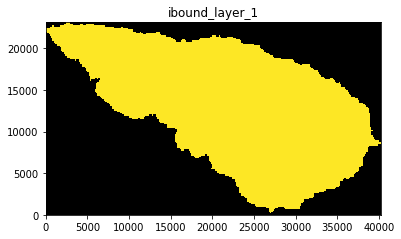

In [119]:
m.bas6.ibound[1].plot()

### 1.2. It is for when pilot points don't exist. We don't want pilot points or care about HK values in inactive cells, but we do need values in constant heads

We are going to use a pyemu helper function to setup pilot points are cell centers for active cells.

In [29]:
'''
# Create pilot points as a shapefile
# we want hk pilot points in the top layer...
prefix_dict = {0:["hk0"], 1:["hk1"], 2:['hk2']}
# prefix_dict = {"hk":[0,1]}
df_pp_hk = pyemu.gw_utils.setup_pilotpoints_grid(ml=m,
                                              prefix_dict=prefix_dict,
                                              pp_dir=working_dir,
                                              tpl_dir=working_dir,
                                              every_n_cell=30,
                                              shapename='pp_hk.shp')
# pp_file = os.path.join(working_dir,"sypp.dat")
# assert os.path.exists(pp_file)
'''

### 1.3. Create dataframe from shapefile

#### **1.3.1. Change Shapefile name**

In [120]:
# change shapefile and file name
shpwd = r'D:/Projects/MiddleBosque/Analysis/mf_pilot'
shp = 'sy03.shp'
ppf = shp[:-3] + 'dat'

#### **1.3.2. Shapefile to Dataframe**

In [121]:
#read file, parse out the records and shapes
shapefile_path = os.path.join(shpwd, shp)
sf = shapefile.Reader(shapefile_path)

#grab the shapefile's field names (omit the first psuedo field)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write the records into a dataframe
shapefile_dataframe = pd.DataFrame(columns=fields, data=records)

#add the coordinate data to a column called "coords"
shapefile_dataframe = shapefile_dataframe.assign(coords=shps)

pp_df = shapefile_dataframe.sort_values(by=['name'])
print(pp_df)

     name             x             y  zone  parval1    k      i      j  \
0  pp_200   2325.000000  20775.000000   1.0      1.0  2.0   15.0   15.0   
1  pp_201  11325.000000  20775.000000   1.0      1.0  2.0   15.0   75.0   
2  pp_202  13880.274951  15773.036733   1.0      1.0  2.0   45.0  105.0   
3  pp_203  21319.794628  19184.841893   1.0      1.0  2.0   45.0  135.0   
4  pp_204  29325.000000  16275.000000   1.0      1.0  2.0   45.0  195.0   
5  pp_205  20325.000000  10254.060685   1.0      1.0  2.0   75.0  135.0   
6  pp_206  21509.800483   9734.265031   1.0      1.0  2.0  105.0  135.0   
7  pp_207  29325.000000   2775.000000   1.0      1.0  2.0  135.0  195.0   
8  pp_208  38784.584724   9295.207638   1.0      1.0  2.0   75.0  225.0   

               tpl parnme  ... pargp partrans parchglim       parlbnd  \
0  ~    hk200    ~  hk200  ...   hk2      log    factor  1.000000e-10   
1  ~    hk202    ~  hk201  ...   hk2      log    factor  1.000000e-10   
2  ~    hk207    ~  hk202  ...

In [133]:
pyemu.utils.pp_utils.write_pp_file(ppf, pp_df)
# pyemu.utils.pp_utils.pilot_points_to_tpl('hahaha.dat')

In [122]:
PP_FMT = {"name": SFMT, "x": FFMT, "y": FFMT, "zone": IFMT, "tpl": SFMT,
          "parval1": FFMT}
def pp_to_tpl(pp_file, tpl_file=None):
#     names = pp_df['parnme'].tolist() # for hk
    names = pp_df['sypar'].tolist() # for sy  
#     names = pp_df['parnme'].tolist() # for river conductance      
    if tpl_file is None:
        tpl_file = pp_file + ".tpl"    
    tpl_entries = ["~    {0}    ~".format(name) for name in names]
    pp_df.loc[:,"tpl"] = tpl_entries
    pp_df.loc[:,"parnme"] = names


    f_tpl = open(tpl_file,'w')
    f_tpl.write("ptf ~\n")
    f_tpl.write(pp_df.to_string(col_space=0,
                              columns=["name","x","y","zone","tpl"],
                              formatters=PP_FMT,
                              justify="left",
                              header=False,
                              index=False) + '\n')    
pp_to_tpl(ppf)

Let's look at ``pp_df`` - it has a lot of useful info

In [123]:
pp_df

,name,x,y,zone,parval1,k,i,j,tpl,parnme,...,pargp,partrans,parchglim,parlbnd,parubnd,scale,offset,dercom,sypar,coords
0,pp_200,2325.000000,20775.000000,1.0,1.0,2.0,15.0,15.0,~ sy200 ~,sy200,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy200,"[[2325.0, 20775.0]]"
1,pp_201,11325.000000,20775.000000,1.0,1.0,2.0,15.0,75.0,~ sy201 ~,sy201,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy201,"[[11325.0, 20775.0]]"
2,pp_202,13880.274951,15773.036733,1.0,1.0,2.0,45.0,105.0,~ sy202 ~,sy202,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy202,"[[13880.274950903433, 15773.036732844426]]"
3,pp_203,21319.794628,19184.841893,1.0,1.0,2.0,45.0,135.0,~ sy203 ~,sy203,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy203,"[[21319.79462785747, 19184.841892867713]]"
4,pp_204,29325.000000,16275.000000,1.0,1.0,2.0,45.0,195.0,~ sy204 ~,sy204,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy204,"[[29325.0, 16275.0]]"
5,pp_205,20325.000000,10254.060685,1.0,1.0,2.0,75.0,135.0,~ sy205 ~,sy205,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy205,"[[20325.0, 10254.060684711409]]"
6,pp_206,21509.800483,9734.265031,1.0,1.0,2.0,105.0,135.0,~ sy206 ~,sy206,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy206,"[[21509.800483541214, 9734.265031348332]]"
7,pp_207,29325.000000,2775.000000,1.0,1.0,2.0,135.0,195.0,~ sy207 ~,sy207,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy207,"[[29325.0, 2775.0]]"
8,pp_208,38784.584724,9295.207638,1.0,1.0,2.0,75.0,225.0,~ sy208 ~,sy208,...,hk2,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1.0,sy208,"[[38784.58472376715, 9295.207638116426]]"


So cool, we now defined pilot points as a set of spatially distributed parameters...but how do go from pilot points to the model input HK array? Answer: geostatistics.  We need to calculate the geostatistical factors (weights) used to form the interpolated value for the HK value at each model cell - its a spatially-weighted combination of pilot point values

# <span style="color:blue">2. Geostatistics</span>

## Need to create Kriging factors and regularization inputs
Following the guidelines in _Approaches to Highly Parameterized Inversion: Pilot-Point Theory, Guidelines, and Research Directions_ https://pubs.usgs.gov/sir/2010/5168/

### First we need to define a couple geostatistical structures (e.g. variograms)

From _PEST Groundwater Data Utilities Part A: Overview_ page 43, there are 4 acceptable variogram types:

 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  
 
 4. *Power*  
### $\gamma\left(h\right)=c\times h^a$
     
 The number refers to `VARTYPE`. `BEARING` and `ANISOTROPY` only apply if there is a principal direction of anisotropy. $h$ is the separation distance, and $a$ is the range, expressed with the `A` parameter.


### First, let's create ``variogram`` and ``GeoStruct`` objects.  

These describe how HK varies spatailly, remember?

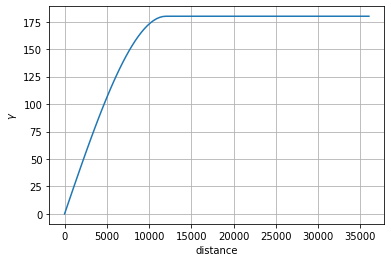

In [124]:
v = pyemu.geostats.SphVario(contribution=180,a=12000, anisotropy=1.8, bearing=120.0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
ax = gs.plot()
ax.grid()
# ax.set_ylim(0,2.0)

Now, let's get an ``OrdinaryKrige`` object, which needs the ``GeoStruct`` as well as the x, y, and name of the pilot point locations (which happens to be in that really cool ``df_pp`` instance)

In [125]:
ok = pyemu.geostats.OrdinaryKrige(gs,pp_df)

Once the ``OrdinaryKrige`` is created, we need to calculate the geostatistical interpolation factors for each model cell.  We do this with the ``.calc_factors_grid()`` method: it needs to know about the model's spatial orientation and also accepts some optional arguments:

### Kriging Processing... it takes time

In [126]:
df = ok.calc_factors_grid(m.sr,
#                           var_filename=pst_name.replace(".pst",".var.ref"),
                          var_filename= shp[:-3] + "var.ref",                          
                          minpts_interp=1,maxpts_interp=30,
                          search_radius=10000000000.0)


   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
starting interp point loop for 41272 points
took 235.438107 seconds


One of the really cool things about geostatistics is that it gives you both the interpolation (factors), but also gives you the uncertainty in the areas between control (pilot) points.  Above, we wrote this uncertainty information to an array that has the same rows and cols as the model grid - this array is very useful for understanding the function of the variogram.

   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse u

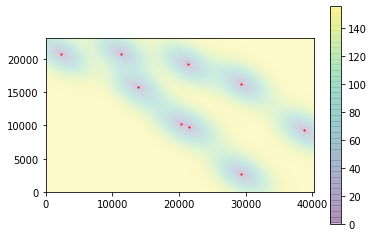

In [127]:
# arr_var = np.loadtxt(pst_name.replace(".pst",".var.ref"))
arr_var = np.loadtxt(shp[:-3] + "var.ref")
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=m.sr.get_extent(),alpha=0.25)
plt.colorbar(p)
ax.scatter(pp_df.x,pp_df.y,marker='.',s=4,color='r')

We see that at the pilot point locations (red dots), the uncertainty in the geostats is minimal...as expected. The call to ``.calc_factors_grid()`` also returns a ``DataFrame`` which has useful info - lets look:

In [128]:
df

,x,y,idist,inames,ifacts,err_var
0,75.0,23025.0,"[3181.9805153394636, 11472.793905583765, 15594.12029255787, 21589.073928012163, 23940.7475028470...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.6409203706260976, 0.04337728599324065, 0.043680151185344594, 0.05112796911271912, 0.023227524...",102.396382
1,225.0,23025.0,"[3077.742679302479, 11325.745008607602, 15461.48457340029, 21441.482567229454, 23814.00619373135...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.6462695131905396, 0.042649322685243615, 0.04305715750218964, 0.050376972281816534, 0.02288227...",101.264006
2,375.0,23025.0,"[2977.4149861918813, 11178.774530332026, 15329.169016232587, 21293.924868197373, 23687.536617281...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.6506586229939499, 0.042052009965838445, 0.0425459750744909, 0.04976075996121847, 0.0225989932...",100.325986
3,525.0,23025.0,"[2881.405906844782, 11031.885604918136, 15197.181983609828, 21146.401535581994, 23561.3431492153...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.6540419450283652, 0.04159157462119755, 0.042151932808814345, 0.04928575595914552, 0.022380625...",99.597457
4,675.0,23025.0,"[2790.161285660741, 10885.081533916042, 15065.5321100081, 20998.913293684855, 23435.430249839137...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.656382707689979, 0.04127302088854673, 0.041879313349829625, 0.048957122852140184, 0.022229546...",99.090640
5,825.0,23025.0,"[2704.163456597992, 10738.365797457265, 14934.228311915387, 20851.460887125497, 23309.8024658098...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.6576153324342985, 0.041416890451691085, 0.04163019991944497, 0.04874349776723305, 0.022147059...",98.822821
6,975.0,23025.0,"[2623.928352680385, 10591.742066345838, 14803.279798313113, 20704.04508155241, 23184.46443192240...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.65768613071791, 0.04234058706407824, 0.041305805769403396, 0.04861204639366073, 0.02213371395...",98.807141
7,1125.0,23025.0,"[2550.0, 10445.214215132211, 14672.696081561668, 20556.66666438371, 23059.42087293337, 24334.825...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.65659442641317, 0.044032335174114194, 0.040910229560916354, 0.048564408710033716, 0.022189664...",99.043190
8,1275.0,23025.0,"[2482.941803587027, 10298.786336263123, 14542.486988703313, 20409.3264455791, 22934.67660541729,...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.6543520267266805, 0.04647857708287066, 0.04044614428439187, 0.048600482932143356, 0.022314262...",99.525770
9,1425.0,23025.0,"[2423.324163210527, 10152.46275541063, 14412.662673195926, 20262.02525844454, 22810.236539656384...","[pp_200, pp_201, pp_202, pp_203, pp_205, pp_206, pp_204, pp_207, pp_208]","[0.6509827420065029, 0.04966404052848442, 0.039914852428509465, 0.04871849263899306, 0.022506083...",100.245109


We see that there is one row for each model cell, and for each row, we see the distance, names, and weight for the "nearby" pilot points.  The interpolated value for cells that have a pilot point at their center only need one weight - 1.0 - and one pilot point.  Other cells are weighted combinations of pilot points.  Is this clear?  

Now we need to save the factors (weights) to a special file that we will use later to quickly generate a new HK array from a set of pilot point values:

In [134]:
ok.to_grid_factors_file(ppf+".fac")

Just for demo purposes, lets generate ``random`` pilot point values and run them through the factors to see what the ``hk`` array looks like

In [57]:
# generate random values
pp_df.loc[:,"parval1"] = np.random.random(pp_df.shape[0])
# save a pilot points file
pyemu.gw_utils.write_pp_file(ppf,pp_df)

In [58]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.gw_utils.fac2real(ppf,factors_file=ppf+".fac",out_file=None)

   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse units from None
   could not parse u

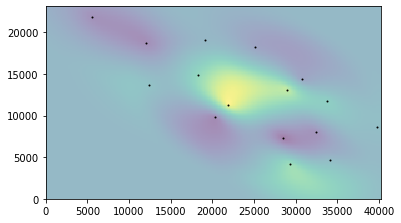

In [59]:
# plot
ax = plt.subplot(111,aspect='equal')
ax.imshow(hk_arr,interpolation="nearest",extent=m.sr.get_extent(),alpha=0.5)
ax.scatter(pp_df.x,pp_df.y,marker='.',s=4,color='k')

What happens if you recalculate the factors using one point for every cell? Change ``max_interp_pts`` to 1 in the ``calc_factors_grid()`` and rerun these cells...

### An aside on geostatistics and covariance matrices

The ``GeoStruct`` object above was used to interpolate from pilot point locations to each node in the grid.  But this same ``GoeStruct`` also has an important information regarding how the pilot points are related to each other spatially---that is, the ``GeoStruct`` object implies a covariance matrix.  Let's form that matrix 

In [129]:
cov = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.parnme)

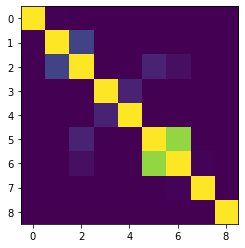

In [130]:
plt.imshow(cov.x)

In [131]:
cov.to_dataframe()

,sy200,sy201,sy202,sy203,sy204,sy205,sy206,sy207,sy208
sy200,180.000000,1.057389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sy201,1.057389,180.000000,36.839765,0.500298,0.000000,0.000000,0.000000,0.000000,0.000000
sy202,0.000000,36.839765,180.000000,0.000000,0.000000,17.501982,7.375035,0.000000,0.000000
sy203,0.000000,0.500298,0.000000,180.000000,17.473084,0.000000,0.000000,0.000000,0.000000
sy204,0.000000,0.000000,0.000000,17.473084,180.000000,0.000000,0.000000,0.000000,0.012129
sy205,0.000000,0.000000,17.501982,0.000000,0.000000,180.000000,150.615266,0.000000,0.000000
sy206,0.000000,0.000000,7.375035,0.000000,0.000000,150.615266,180.000000,2.064578,0.000000
sy207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.064578,180.000000,0.000000
sy208,0.000000,0.000000,0.000000,0.000000,0.012129,0.000000,0.000000,0.000000,180.000000


What do these numbers mean?  Why should you care?  Well, this covariance matrix plays an important role in uncertainty quantification, as well as in governing the way pilot point parameters are adjusted during calibration

# For river Bed conductance interpolation

In [137]:
# interpolate the pilot point values to the grid
riv_cond = pyemu.gw_utils.fac2real(ppf,factors_file=ppf+".fac",out_file=None)
ppf

'sy03.dat'

In [136]:
np.shape(riv_cond)

(154, 268)

## 1. get only river grids

In [139]:
df_riv = pd.read_csv(
                    shpwd + "\\mf\\ss_072519.riv",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )

In [136]:
new_riv_cf = [riv_cond[df_riv.iloc[i, 0], df_riv.iloc[i, 1]] for i in range(len(df_riv))]

In [137]:
df_riv.iloc[:, 4] = new_riv_cf
df_riv.iloc[:, 4] = df_riv.iloc[:, 4].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 3] = df_riv.iloc[:, 3].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 5] = df_riv.iloc[:, 5].map(lambda x: '{:.10e}'.format(x))

In [138]:
with open(os.path.join(shpwd + "\\mf", "ss_072519.riv"), 'w') as f:
    f.write("# RIV: River package file created on 7/25/2019 by ModelMuse version 4.0.0.0." + "\n")
    f.write("  1467     9 AUXILIARY IFACE # DataSet 2: MXACTC IRIVCB Option" + "\n")
    f.write("  1467     0 # Data Set 5: ITMP NP Stress period 1" + "\n")    
    df_riv.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  encoding='utf-8')


# Build instruction files (Streamflow / Watertable)

### 1. Streamflow (channel_day.txt)

In [16]:
import csv

wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_pp"
df_str = pd.read_csv(
                    wd2 + "\\channel_day.txt",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )

# '''
test = []
# test2 = [] 
for i in range(len(df_str)):
    if (df_str.iloc[i, 6] == 'cha53') & (df_str.iloc[i, 3] >= 1993) :
        a = 'l1 w w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
#         test2.append(df_str.iloc[i, 8])
    else:
        a = 'l1'
        test.append(a)

with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")
    f.write('l1' + "\n") # this for 3 skiprows
    f.write('l1' + "\n")
    f.write('l1' + "\n")
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])

### 2. Watertable (modflow_cell_obs.txt)

In [57]:
import csv
import pandas as pd
import numpy as np

st_date = '1/1/1980'
wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_pp"
df_wt = pd.read_csv(
                    wd2 + "\\modflow_cell_obs.txt",
                    delim_whitespace=True,
                    skiprows=1,
#                     usecols=[1,2],
                    header=None
                    )
df_wt.index = pd.date_range(st_date, periods=len(df_wt))
# print(df_str)

co1L = []
co2D = []



# for i in range(len(df_str)):
#     if ((df_wt.index[i].strftime('%Y%m%d') >= '19850821') & (df_wt.index[i].strftime('%Y%m%d') <= '19860507')):
#         print('true')
df_wt['date'] = df_wt.index.strftime('%Y%m%d')
# df_wt['test'] = CO1L['8/21/1985':'5/7/1986']
# df_wt['test'] = df_wt[(df_wt.index >= '08/21/1985') & (df_wt.index <= '05/07/1986')] = 'w'
df_wt['wt2_919'] = np.where((df_wt.index >= '10/21/1985') & (df_wt.index <= '03/07/1986'), ('l1 !wt2_919_'+df_wt['date']+'!'), 'l1 w')
df_wt['wt1_653'] = np.where((df_wt.index >= '11/30/1985') & (df_wt.index <= '02/01/1986'), ('!wt1_653_'+df_wt['date']+'!'), ' w')

with open('wt.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")
    df_wt.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  columns=('wt2_919','wt1_653'),
                  encoding='utf-8')
    

print(os.getcwd())

'''
test = []
for i in range(len(df_str)):
    if df_str.iloc[i, 6] == 'cha53':
        a = 'l1 w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
    else:
        a = 'l1'
        test.append(a)


with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")  
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])
'''

D:\Projects\MiddleBosque\Analysis\SWAT+MODFLOW Model_pp


'\ntest = []\nfor i in range(len(df_str)):\n    if df_str.iloc[i, 6] == \'cha53\':\n        a = \'l1 w w w w w w w w \'\n        b = \'!str_{}{:02d}{:02d}!\'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])\n        test.append(a+b)\n    else:\n        a = \'l1\'\n        test.append(a)\n\n\nwith open(\'str.ins\', "w", newline=\'\') as f:\n    f.write("pif ~" + "\n")  \n    writer = csv.writer(f)\n    for row in test:\n        writer.writerow([row])\n'

### Building a control file using these pilot points

There's a fair amount of support in pyemu for building control files and setting PEST inferfaces.  Here we will only briefly touch on some of the basic components.  If you have created template files and instruction files, and have used our proposed naming convention, then you can quickly generate a control file using the following call

In [58]:
import os
import pyemu

working_dir = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_pp"
os.chdir(working_dir)
io_files = pyemu.helpers.parse_dir_for_io_files('.')
pst = pyemu.Pst.from_io_files(*io_files)
pyemu.helpers.pst_from_io_files(io_files[0], io_files[1], io_files[2], io_files[3], 'test.pst')

# print(os.chdir(".."))
io_files

noptmax:30, npar_adj:124, nnz_obs:4950


(['calibration.cal.tpl',
  'hk01.dat.tpl',
  'hk02.dat.tpl',
  'hk03.dat.tpl',
  'hk04.dat.tpl',
  'hk05.dat.tpl',
  'riv_cond.dat.tpl',
  'sy01.dat.tpl',
  'sy02.dat.tpl',
  'sy03.dat.tpl',
  'sy04.dat.tpl',
  'sy05.dat.tpl'],
 ['calibration.cal',
  'hk01.dat',
  'hk02.dat',
  'hk03.dat',
  'hk04.dat',
  'hk05.dat',
  'riv_cond.dat',
  'sy01.dat',
  'sy02.dat',
  'sy03.dat',
  'sy04.dat',
  'sy05.dat'],
 ['channel_day.txt.ins', 'modflow_cell_obs.txt.ins'],
 ['channel_day.txt', 'modflow_cell_obs.txt'])

The ``parse_dir_for_io_files()`` helper is looking for files with the ".tpl" and ".ins" extension.  This assumes that the corresponding model input and model output files are the same name, minus the ".tpl" and ".ins" extension, respectively.  These file lists are then passed to another helper, which builds a basic control file for you (``Pst.from_io_files()``).  Let's look at this generic ``Pst`` instance:

In [59]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
alpha,alpha,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
awc,awc,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
cn2,cn2,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
delay,delay,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
epco,epco,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
esco,esco,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
flo_min,flo_min,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk001,hk001,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk007,hk007,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk008,hk008,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


In [79]:
for i in range(len(par)):
    if (par.iloc[i, 0][:3]) == 'hk0':
        par.iloc[i, 6] = 'par_hk_1'
    elif (par.iloc[i, 0][:3]) == 'hk1':
        par.iloc[i, 6] = 'par_hk_2'
    elif (par.iloc[i, 0][:3]) == 'hk2':
        par.iloc[i, 6] = 'par_hk_3'
    elif (par.iloc[i, 0][:3]) == 'hk3':
        par.iloc[i, 6] = 'par_hk_4'           
    elif (par.iloc[i, 0][:3]) == 'hk4':
        par.iloc[i, 6] = 'par_hk_5'   

    elif par.iloc[i, 0][:3] == 'sy0':
        par.iloc[i, 6] = 'par_sy_1'
    elif par.iloc[i, 0][:3] == 'sy1':
        par.iloc[i, 6] = 'par_sy_2'        
    elif par.iloc[i, 0][:3] == 'sy2':
        par.iloc[i, 6] = 'par_sy_3'
    elif par.iloc[i, 0][:3] == 'sy3':
        par.iloc[i, 6] = 'par_sy_4'
    elif par.iloc[i, 0][:3] == 'sy4':
        par.iloc[i, 6] = 'par_sy_5'

    elif par.iloc[i, 0][:5] == 'rivcd':
        par.iloc[i, 6] = 'par_rivcd'
    else:
        par.iloc[i, 6] = 'str_par'

In [80]:
par = par.sort_values(by=['pargp', 'parnme'])
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk001,hk001,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk007,hk007,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk008,hk008,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk009,hk009,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk010,hk010,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk011,hk011,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk012,hk012,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk013,hk013,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk014,hk014,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1
hk015,hk015,log,factor,1.0,1.100000e-10,1.100000e+10,par_hk_1,1.0,0.0,1


### 3. Set par ranges and values for MODFLOW

In [87]:
# for MODFLOW parameters
for i in range(len(par)):
    if (par.iloc[i, 0][:2]) == 'hk':
        par.iloc[i, 4] = 1.100000e-05
        par.iloc[i, 5] = 1.100000e+05
    elif par.iloc[i, 0][:2] == 'sy':
        par.iloc[i, 3] = 0.200000e+00 
        par.iloc[i, 4] = 1.100000e-03
        par.iloc[i, 5] = 0.500000e+00        
    elif par.iloc[i, 0][:5] == 'rivcd':
        par.iloc[i, 3] = 1.000000e+02 
        par.iloc[i, 4] = 1.100000e-07
        par.iloc[i, 5] = 1.100000e+07
#     else:
#         par.iloc[i, 6] = 'str_par'


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk001,hk001,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk007,hk007,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk008,hk008,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk009,hk009,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk010,hk010,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk011,hk011,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk012,hk012,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk013,hk013,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk014,hk014,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1
hk015,hk015,log,factor,1.0,1.100000e-05,1.100000e+05,par_hk_1,1.0,0.0,1


### 3. Set par ranges and values for SWAT+

In [92]:
par.loc['cn2']

parnme           cn2
partrans         log
parchglim     factor
parval1            1
parlbnd          0.1
parubnd      1.1e+10
pargp        str_par
scale              1
offset             0
dercom             1
Name: cn2, dtype: object

In [93]:
# CN2
par.loc['cn2', 'parval1'] = 25
par.loc['cn2', 'parlbnd'] = 0.0001
par.loc['cn2', 'parubnd'] = 100
par.loc['cn2', 'offset'] = -50

# awc
par.loc['awc', 'parval1'] = 141
par.loc['awc', 'parlbnd'] = 0.1
par.loc['awc', 'parubnd'] = 190
par.loc['awc', 'offset'] = -100

# esco
par.loc['esco', 'parval1'] = 0.5
par.loc['esco', 'parlbnd'] = 0.1
par.loc['esco', 'parubnd'] = 0.99
par.loc['esco', 'offset'] = 0

# epco
par.loc['epco', 'parval1'] = 0.5
par.loc['epco', 'parlbnd'] = 0.1
par.loc['epco', 'parubnd'] = 0.99
par.loc['epco', 'offset'] = 0

# k
par.loc['k', 'parval1'] = 200
par.loc['k', 'parlbnd'] = 0.1
par.loc['k', 'parubnd'] = 300
par.loc['k', 'offset'] = -150

# alpha
par.loc['alpha', 'parval1'] = 0.7
par.loc['alpha', 'parlbnd'] = 0.001
par.loc['alpha', 'parubnd'] = 0.95
par.loc['alpha', 'offset'] = 0

# delay
par.loc['delay', 'parval1'] = 3.0
par.loc['delay', 'parlbnd'] = 0.001
par.loc['delay', 'parubnd'] = 500
par.loc['delay', 'offset'] = 0

# flo_min
par.loc['flo_min', 'parval1'] = 0.001
par.loc['flo_min', 'parlbnd'] = 0.0001
par.loc['flo_min', 'parubnd'] = 5000
par.loc['flo_min', 'offset'] = 0

# revap_co
par.loc['revap_co', 'parval1'] = 0.1
par.loc['revap_co', 'parlbnd'] = 0.02
par.loc['revap_co', 'parubnd'] = 0.2
par.loc['revap_co', 'offset'] = 0

# revap_min
par.loc['revap_min', 'parval1'] = 100
par.loc['revap_min', 'parlbnd'] = 0.00001
par.loc['revap_min', 'parubnd'] = 500
par.loc['revap_min', 'offset'] = 0


par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk001,hk001,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk007,hk007,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk008,hk008,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk009,hk009,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk010,hk010,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk011,hk011,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk012,hk012,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk013,hk013,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk014,hk014,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1
hk015,hk015,log,factor,1.000,0.000011,110000.00,par_hk_1,1.0,0.0,1



Cool - the other tpl files were found and parsed - parameter listed in them were added to the control file.  But we have generic entries for initial values bounds...

In [94]:
obd = pst.observation_data
obd

,obsnme,obsval,weight,obgnme
str_19930101,str_19930101,17.884800,1.0,ob_str
str_19930102,str_19930102,18.576000,1.0,ob_str
str_19930103,str_19930103,18.576000,1.0,ob_str
str_19930104,str_19930104,19.180800,1.0,ob_str
str_19930105,str_19930105,33.091200,1.0,ob_str
str_19930106,str_19930106,15.465600,1.0,ob_str
str_19930107,str_19930107,16.070400,1.0,ob_str
str_19930108,str_19930108,16.675200,1.0,ob_str
str_19930109,str_19930109,30.240000,1.0,ob_str
str_19930110,str_19930110,27.648000,1.0,ob_str


In [82]:
for i in range(len(obd)):
    if obd.iloc[i, 0][:3] == 'str':
        obd.iloc[i, 3] = 'ob_str'
    elif obd.iloc[i, 0][:3] == 'wt1':
        obd.iloc[i, 3] = 'ob_wt_1'
    else:
        obd.iloc[i, 3] = 'ob_wt_2'

In [83]:
obd

,obsnme,obsval,weight,obgnme
str_19930101,str_19930101,17.884800,1.0,ob_str
str_19930102,str_19930102,18.576000,1.0,ob_str
str_19930103,str_19930103,18.576000,1.0,ob_str
str_19930104,str_19930104,19.180800,1.0,ob_str
str_19930105,str_19930105,33.091200,1.0,ob_str
str_19930106,str_19930106,15.465600,1.0,ob_str
str_19930107,str_19930107,16.070400,1.0,ob_str
str_19930108,str_19930108,16.675200,1.0,ob_str
str_19930109,str_19930109,30.240000,1.0,ob_str
str_19930110,str_19930110,27.648000,1.0,ob_str


### 3. Import measured streamflow and watertable elevation

In [75]:
# streamflow
# streamflow.obd
df_riv = pd.read_csv(
                    "streamflow.obd",
                    delim_whitespace=True,
                    index_col=0,
                    parse_dates=True,
                    )
df_riv = df_riv['1993/1/1': '2005/12/31']

# convert cms to ham
df_riv['cvt'] = df_riv.FLOW_OUT * 8.64

# change values
obd.iloc[:len(df_riv['cvt']), 1] = df_riv['cvt'].tolist()

# modflow.obd
st_date = '1/1/1980'
wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_pp"
df_wt = pd.read_csv(
                    wd2 + "\\modflow.obd",
#                     delim_whitespace=True,
                    sep=r'\s+',
                    delimiter='\t',
#                     skiprows=1,
                    index_col=0,
                    usecols=[0,1,2],
#                     header=None,
                    parse_dates=True
                    )

st_d_2nd = '10/21/1985'
ed_d_2nd = '03/07/1986'
st_d_1st = '11/30/1985'
ed_d_1st = '02/01/1986'
co1L = df_wt[st_d_2nd:ed_d_2nd].C01L_22919_wt.tolist()
co2D = df_wt[st_d_1st:ed_d_1st].C02D_22653_wt.tolist()

wt_total = co2D + co1L
# print(len(wt_total))


# change values
obd.iloc[len(df_riv['cvt']):, 1] = wt_total


# obd.iloc[:len(df_riv['cvt']), 1] = df_riv['cvt'].tolist()




In [84]:
obd.to_csv('test11.txt', sep='\t', float_format='%15.10e', header=False, index=False,)

### 4. Export control file

In [95]:
with open('mb_pp.pst', "w", newline='') as f:
    f.write("pcf" + "\n")
    f.write("* control data" + "\n")
    par.to_csv(f, sep='\t',
                  header=False,
                  index=False,
                  float_format='%15.10e', 
                  line_terminator='\n', 
#                   columns=('2nd','1st'),
                  encoding='utf-8')
    f.write("* observation groups" + "\n")
    f.write("* observation data" + "\n")
    obd.to_csv(f, sep='\t',
                  header=False,
                  index=False,
                  float_format='%15.10e',
                  line_terminator='\n', 
#                   columns=('2nd','1st'),
                  encoding='utf-8')

also cool - the instruction files in the directory were also found and parsed so that observation listed in the instruction files were added as well. There are some subtlies here, but we will skip them for now.

## Regularization

Regularization is ....

in pyemu, we can add two forms of regularization:
- preferred value: we want the parameter values to stay as close to the initial values as possible
- preferred difference: we prefer the differences in parameter values to be minimized

Preferred value is easy to understand, we simply add ``prior_information`` to the control file to enforce this condition.  pyemu uses a helper for this:

In [36]:
# load the pre-constructed pst
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [37]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=False)

In [38]:
pst.prior_information

,pilbl,equation,obgnme,weight
0,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,1.0
1,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,1.0
2,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,1.0
3,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,1.0
4,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,1.0
5,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,1.0
6,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,1.0
7,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,1.0
8,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,1.0
9,hk09,1.0 * log(hk09) = 6.989700E-01,regulhk,1.0


Ok, that's fine, but should the weight on preferring HK not to change be the same as preferring recharge not to change?  Seems like we would want recharge to change less than HK.  This preference can be expressed by using the parameter bounds to form the weights

In [43]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=True)

In [44]:
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,0.500000
hk01,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,0.500000
hk02,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,0.500000
hk03,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,0.500000
hk04,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,0.500000
hk05,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,0.500000
hk06,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,0.500000
hk07,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,0.500000
hk08,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,0.500000


Now we are really preferring recharge not to change...good!

So what about preferred difference regularization?  Well pyemu can do that too.  Remember that ``Cov``ariance matrix we built above? It expresses the spatial relationship between pilot points, so we use to setup these prior information equations:

In [45]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix


Exception: Matrix.indices(): name not found: porosity

In [46]:
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,0.500000
hk01,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,0.500000
hk02,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,0.500000
hk03,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,0.500000
hk04,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,0.500000
hk05,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,0.500000
hk06,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,0.500000
hk07,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,0.500000
hk08,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,0.500000


What happened?  We replace the preferred value equations with a bunch of new equations.  These equations each include two parameter names and have different weights - can you guess what the weights are?  The weights are the pearson correlation coefficients (CC) between the pilot points (remember those from way back?).  These CC values are calculated from the covariance matrix, which is implied by the geostatistical structure...whew! 

# For river Bed conductance interpolation

In [62]:
# interpolate the pilot point values to the grid
riv_cond = pyemu.gw_utils.fac2real(ppf,factors_file=ppf+".fac",out_file=None)

In [64]:
np.shape(riv_cond)

(154, 268)

## 1. get only river grids

In [139]:
df_riv = pd.read_csv(
                    shpwd + "\\mf\\ss_072519.riv",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )

In [136]:
new_riv_cf = [riv_cond[df_riv.iloc[i, 0], df_riv.iloc[i, 1]] for i in range(len(df_riv))]

In [137]:
df_riv.iloc[:, 4] = new_riv_cf
df_riv.iloc[:, 4] = df_riv.iloc[:, 4].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 3] = df_riv.iloc[:, 3].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 5] = df_riv.iloc[:, 5].map(lambda x: '{:.10e}'.format(x))

In [138]:
with open(os.path.join(shpwd + "\\mf", "ss_072519.riv"), 'w') as f:
    f.write("# RIV: River package file created on 7/25/2019 by ModelMuse version 4.0.0.0." + "\n")
    f.write("  1467     9 AUXILIARY IFACE # DataSet 2: MXACTC IRIVCB Option" + "\n")
    f.write("  1467     0 # Data Set 5: ITMP NP Stress period 1" + "\n")    
    df_riv.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  encoding='utf-8')


# Build instruction files (Streamflow / Watertable)

### 1. Streamflow (channel_day.txt)

In [68]:
import csv

wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_middle_bosque"
df_str = pd.read_csv(
                    wd2 + "\\channel_day - Copy.txt",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )
test = []
for i in range(len(df_str)):
    if df_str.iloc[i, 6] == 'cha53':
        a = 'l1 w w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
    else:
        a = 'l1'
        test.append(a)


with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")  
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])


### 2. Watertable (modflow_cell_obs.txt)

In [49]:
import csv
import pandas as pd
import numpy as np

st_date = '1/1/1980'
wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_middle_bosque"
df_wt = pd.read_csv(
                    wd2 + "\\modflow_cell_obs.txt",
                    delim_whitespace=True,
                    skiprows=1,
#                     usecols=[1,2],
                    header=None
                    )
df_wt.index = pd.date_range(st_date, periods=len(df_wt))
# print(df_str)

co1L = []
co2D = []



# for i in range(len(df_str)):
#     if ((df_wt.index[i].strftime('%Y%m%d') >= '19850821') & (df_wt.index[i].strftime('%Y%m%d') <= '19860507')):
#         print('true')
df_wt['date'] = df_wt.index.strftime('%Y%m%d')
# df_wt['test'] = CO1L['8/21/1985':'5/7/1986']
# df_wt['test'] = df_wt[(df_wt.index >= '08/21/1985') & (df_wt.index <= '05/07/1986')] = 'w'
df_wt['2nd'] = np.where((df_wt.index >= '08/21/1985') & (df_wt.index <= '05/07/1986'), ('l1 !wt_2nd'+df_wt['date']+'!'), 'l1 w')
df_wt['1st'] = np.where((df_wt.index >= '09/30/1985') & (df_wt.index <= '04/01/1986'), ('!wt_1nd'+df_wt['date']+'!'), ' w')


print(df_wt)

with open('wt.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")
    df_wt.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  columns=('2nd','1st'),
                  encoding='utf-8')

'''
test = []
for i in range(len(df_str)):
    if df_str.iloc[i, 6] == 'cha53':
        a = 'l1 w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
    else:
        a = 'l1'
        test.append(a)


with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")  
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])
'''

                   0         1      date   2nd 1st
1980-01-01  255.5776  253.4422  19800101  l1 w   w
1980-01-02  255.6870  253.5240  19800102  l1 w   w
1980-01-03  255.7828  253.5971  19800103  l1 w   w
1980-01-04  255.8695  253.6645  19800104  l1 w   w
1980-01-05  255.9489  253.7285  19800105  l1 w   w
...              ...       ...       ...   ...  ..
2005-12-27  263.4627  261.2057  20051227  l1 w   w
2005-12-28  263.4421  261.1927  20051228  l1 w   w
2005-12-29  263.4519  261.1992  20051229  l1 w   w
2005-12-30  263.4284  261.1831  20051230  l1 w   w
2005-12-31  263.4290  261.1830  20051231  l1 w   w

[9497 rows x 5 columns]


'\ntest = []\nfor i in range(len(df_str)):\n    if df_str.iloc[i, 6] == \'cha53\':\n        a = \'l1 w w w w w w w w \'\n        b = \'!str_{}{:02d}{:02d}!\'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])\n        test.append(a+b)\n    else:\n        a = \'l1\'\n        test.append(a)\n\n\nwith open(\'str.ins\', "w", newline=\'\') as f:\n    f.write("pif ~" + "\n")  \n    writer = csv.writer(f)\n    for row in test:\n        writer.writerow([row])\n'

In [148]:
a = np.full((33, 55), 10)

In [149]:
np.shape(a)

(33, 55)

In [155]:
np.savetxt('test.txtt', a, fmt='%.12e', delimiter='\t')
np.savetxt('vtest.txtt', a/10, fmt='%.12e', delimiter='\t')

In [154]:
b = np.loadtxt('test.txtt')
b/10

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [111]:
with open('hk04.dat', 'r') as f:
    data = [x.strip().split() for x in f if x.strip()]
hk = float(data[0][4])
hk

1.0

In [120]:
data_fac = ['hk01.dat', 'hk02.dat', 'hk03.dat', 'sy01.dat', 'sy02.dat', 'sy03.dat']
for i in data_fac:
    if i[:2] == 'hk':
        print('true')



true
true
true


In [118]:
print(a)

hk01.dat.ref


In [119]:
b/10

TypeError: unsupported operand type(s) for /: 'str' and 'int'